# Week 13-1 - RANDOM FORESTS AND BOOSTING

This lecture is comprised of 4 parts:

- 1. CART Baseline

- 2. Random Forests (basic model and cross-validation)

- 3. Gradient Boosted Trees (basic model and cross-validation)

- 4. Final Comparison

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [4]:
ctr = pd.read_csv("CTR.csv")
ctr.info()
ctr.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6057 entries, 0 to 6056
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CTR            6057 non-null   float64
 1   titleWords     6057 non-null   int64  
 2   adWords        6057 non-null   int64  
 3   depth          6057 non-null   int64  
 4   position       6057 non-null   int64  
 5   advCTR         6057 non-null   float64
 6   advCTRInPos    6057 non-null   float64
 7   queryCTR       6057 non-null   float64
 8   queryCTRInPos  6057 non-null   float64
 9   gender         6057 non-null   object 
 10  age            6057 non-null   object 
dtypes: float64(5), int64(4), object(2)
memory usage: 520.7+ KB


,CTR,titleWords,adWords,depth,position,advCTR,advCTRInPos,queryCTR,queryCTRInPos,gender,age
0,0.0000,8,17,1,1,0.0136,0.0153,0.0000,0.0000,male,0-12
1,0.0000,9,19,3,3,0.0199,0.0088,0.0394,0.0125,male,25-30
2,0.0675,6,30,2,1,0.0825,0.1002,0.0200,0.0256,female,13-18
3,0.0000,5,19,3,2,0.0116,0.0090,0.0042,0.0017,female,25-30
4,0.0000,10,22,1,1,0.0186,0.0284,0.0294,0.0431,female,0-12


In [5]:
def OSR2(model, X_test, y_test, y_train):
    
    y_pred = model.predict(X_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
                 
    return (1 - SSE/SST)

## 1. CART BASELINE

### Decision Tree Regressor with CV

We will use a standard decision tree to establish a reference against which to evaluate the ensemble models

#### 1.0 Train test split

In [6]:
from sklearn.model_selection import train_test_split

y = ctr['CTR']
X = pd.get_dummies(ctr.drop(['CTR'], axis=1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)
X_train.shape, X_test.shape

((4239, 18), (1818, 18))

#### 1.1 Define the grid values and perform the Grid Search Cross-Validation

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold

grid_values = {'ccp_alpha': np.linspace(0, 0.001, 51)}

dtr = DecisionTreeRegressor(min_samples_leaf=5, min_samples_split=20, random_state=88)
### Note that the line below is important. It ensures that the training data is split into
### five folds randomly. Recall what we've seen in the discussion slides that by default,
### GridSearchCV will split the training data without shuffling. 
cv = KFold(n_splits=5,random_state=1,shuffle=True) 
### by setting random_state as a fixed number, we ensure that each time the GridSearchCV splits data, we get the 
### same split.
dtr_cv = GridSearchCV(dtr, param_grid=grid_values, scoring='r2', cv=cv, verbose=0)
dtr_cv.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=DecisionTreeRegressor(min_samples_leaf=5,
                                             min_samples_split=20,
                                             random_state=88),
             param_grid={'ccp_alpha': array([0.0e+00, 2.0e-05, 4.0e-05, 6.0e-05, 8.0e-05, 1.0e-04, 1.2e-04,
       1.4e-04, 1.6e-04, 1.8e-04, 2.0e-04, 2.2e-04, 2.4e-04, 2.6e-04,
       2.8e-04, 3.0e-04, 3.2e-04, 3.4e-04, 3.6e-04, 3.8e-04, 4.0e-04,
       4.2e-04, 4.4e-04, 4.6e-04, 4.8e-04, 5.0e-04, 5.2e-04, 5.4e-04,
       5.6e-04, 5.8e-04, 6.0e-04, 6.2e-04, 6.4e-04, 6.6e-04, 6.8e-04,
       7.0e-04, 7.2e-04, 7.4e-04, 7.6e-04, 7.8e-04, 8.0e-04, 8.2e-04,
       8.4e-04, 8.6e-04, 8.8e-04, 9.0e-04, 9.2e-04, 9.4e-04, 9.6e-04,
       9.8e-04, 1.0e-03])},
             scoring='r2')

#### 1.2 Select the best hyperparameter

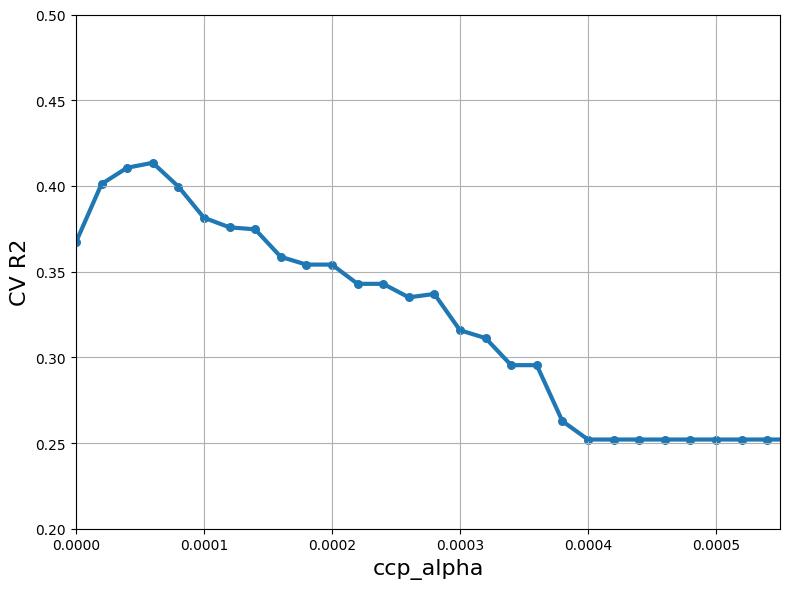

In [8]:
ccp_alpha = dtr_cv.cv_results_['param_ccp_alpha'].data
R2_scores = dtr_cv.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.xlabel('ccp_alpha', fontsize=16)
plt.ylabel('CV R2', fontsize=16)
plt.scatter(ccp_alpha, R2_scores, s=30)
plt.plot(ccp_alpha, R2_scores, linewidth=3)
plt.grid(True, which='both')
plt.xlim([0, 0.00055])
plt.ylim([0.2, 0.5])

plt.tight_layout()
plt.show()

In [9]:
print('Best ccp_alpha', dtr_cv.best_params_)

Best ccp_alpha {'ccp_alpha': 6.000000000000001e-05}


#### 1.3 Evaluate the model performance (trained on the entire training set)

In [10]:
# Model Evaluation
print('Cross-validated R2:', round(dtr_cv.best_score_, 5))
print('OSR2:', round(OSR2(dtr_cv, X_test, y_test, y_train), 5))

Cross-validated R2: 0.41349
OSR2: 0.4819


## 2. RANDOM FORESTS

### 2.1 Random Forest Regressor

In [11]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=5, min_samples_leaf=5, 
                           n_estimators = 500, random_state=88, verbose=2)
# Note: you can change the verbose parameter to control how much training progress is printed.
rf.fit(X_train, y_train)

building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
b

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.6s


building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 83 of 500
building tree 84 of 500
building tree 85 of 500
building tree 86 of 500
building tree 87 of 500
building tree 88 of 500
building tree 89 of 500
building tree 90 of 500
building tree 91

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.9s


building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500
building tree 198 of 500
building tree 199 of 500
building tree 200 of 500
building tree 201 of 500
building tree 202 of 500
building tree 203 of 500
building tree 204 of 500
building tree 205 of 500
building tree 206 of 500
building tree 207 of 500
building tree 208 of 500
building tree 209 of 500


[Parallel(n_jobs=1)]: Done 364 tasks      | elapsed:    6.8s


building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500
building tree 414 of 500
building tree 415 of 500


RandomForestRegressor(max_features=5, min_samples_leaf=5, n_estimators=500,
                      random_state=88, verbose=2)

In [12]:
rf.verbose = False

print('OSR2:', round(OSR2(rf, X_test, y_test, y_train), 5))

OSR2: 0.56445


#### Feature Importance

In [13]:
pd.DataFrame({'Feature' : X_train.columns, 
              'Importance score': 100*rf.feature_importances_}).round(1)

,Feature,Importance score
0,titleWords,3.7
1,adWords,3.4
2,depth,2.3
3,position,2.2
4,advCTR,23.6
5,advCTRInPos,32.6
6,queryCTR,10.0
7,queryCTRInPos,17.9
8,gender_female,0.8
9,gender_male,0.5


### 2.2 Random Forest Regressor with CV

#### 2.2.1 Define the grid values and perform the Grid Search Cross-Validation

In [14]:
import time

grid_values = {'max_features': np.linspace(1,25,25, dtype='int32'),
               'min_samples_leaf': [5],
               'n_estimators': [40],
               'random_state': [88]} 

tic = time.time()

rf2 = RandomForestRegressor() 
# Note: here we set verbose=2 to keep track of the progress (the running time) of the cross validation. 
cv = KFold(n_splits=5,random_state=2333,shuffle=True) 
rf_cv = GridSearchCV(rf2, param_grid=grid_values, scoring='r2', cv=cv,verbose=2)
rf_cv.fit(X_train, y_train)

toc = time.time()

print('time:', round(toc-tic, 2),'s')

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[CV] END max_features=1, min_samples_leaf=5, n_estimators=40, random_state=88; total time=   0.2s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=40, random_state=88; total time=   0.2s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=40, random_state=88; total time=   0.2s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=40, random_state=88; total time=   0.2s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=40, random_state=88; total time=   0.2s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=40, random_state=88; total time=   0.3s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=40, random_state=88; total time=   0.3s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=40, random_state=88; total time=   0.3s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=40, random_state=88; total time=   0.3s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=40, random_state=88; total time=   0.2s
[CV] END max_feature

####  2.2.2 Select the best hyperparameter

(0.4, 0.55)

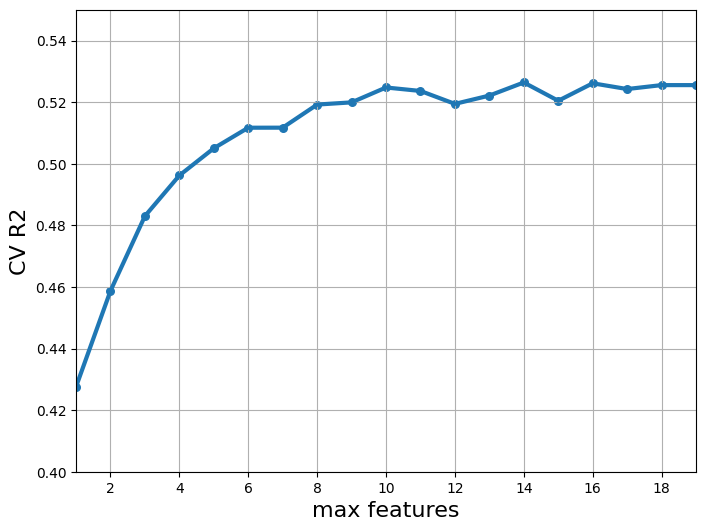

In [15]:
max_features = rf_cv.cv_results_['param_max_features'].data
R2_scores = rf_cv.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.xlabel('max features', fontsize=16)
plt.ylabel('CV R2', fontsize=16)
plt.scatter(max_features, R2_scores, s=30)
plt.plot(max_features, R2_scores, linewidth=3)
plt.grid(True, which='both')
plt.xlim([1, 19])
plt.ylim([0.4, 0.55])

In [16]:
print(rf_cv.best_params_)

{'max_features': 14, 'min_samples_leaf': 5, 'n_estimators': 40, 'random_state': 88}


#### 2.2.3 Evaluate the model performance (trained on the entire training set)

In [17]:
print('Cross-validated R2:', round(rf_cv.best_score_, 5))
print('OSR2:', round(OSR2(rf_cv, X_test, y_test, y_train), 5))

Cross-validated R2: 0.52638
OSR2: 0.55923


#### 2.2.4 Feature Importance

In [18]:
pd.DataFrame({'Feature' : X_train.columns,  
              'Importance score': 100*rf_cv.best_estimator_.feature_importances_}).round(1)


,Feature,Importance score
0,titleWords,3.6
1,adWords,3.4
2,depth,1.7
3,position,0.6
4,advCTR,17.6
5,advCTRInPos,41.4
6,queryCTR,7.5
7,queryCTRInPos,21.1
8,gender_female,0.5
9,gender_male,0.5


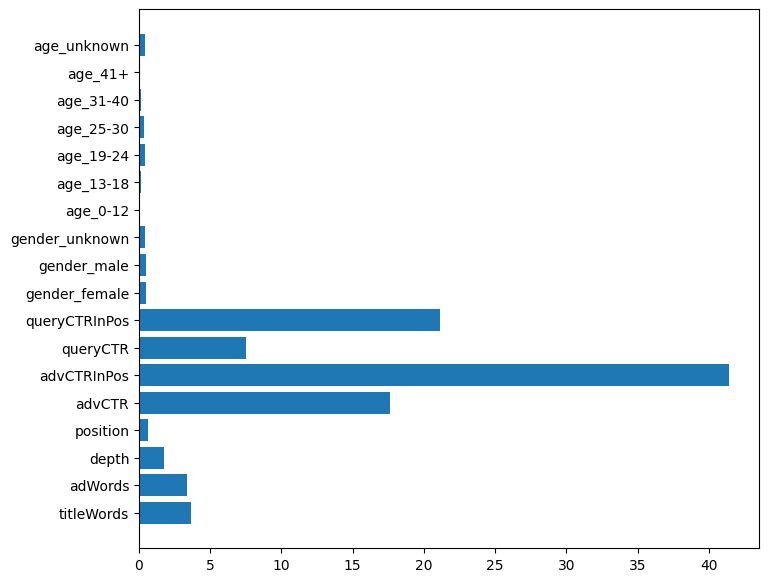

In [19]:
plt.figure(figsize=(8,7))
plt.barh(X_train.columns, 100*rf_cv.best_estimator_.feature_importances_)
plt.show()

## 3. GRADIENT BOOSTED TREES

### 3.1 Gradient Boosting Regressor

Controlling tree size using `max_leaf_nodes` vs. `max_depth`: https://scikit-learn.org/stable/modules/ensemble.html#controlling-the-tree-size

We choose use `max_leaf_nodes` as our primary parameter to control the size of the tree: we set `max_depth` to a large value so that it does not interfere with the construction of the trees. 

In [20]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=2000, learning_rate= 0.001, max_leaf_nodes=3,
                                max_depth=10, min_samples_leaf=10, random_state=88, verbose=1) 
gbr.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.0060           30.35s
         2           0.0060           30.59s
         3           0.0060           29.80s
         4           0.0060           29.27s
         5           0.0060           29.48s
         6           0.0060           31.03s
         7           0.0060           32.31s
         8           0.0060           32.33s
         9           0.0060           32.27s
        10           0.0060           31.88s
        20           0.0059           31.09s
        30           0.0059           30.56s
        40           0.0059           30.04s
        50           0.0058           29.85s
        60           0.0058           29.50s
        70           0.0058           29.37s
        80           0.0057           29.25s
        90           0.0057           29.12s
       100           0.0057           29.08s
       200           0.0054           27.20s
       300           0.0051           25.42s
       40

GradientBoostingRegressor(learning_rate=0.001, max_depth=10, max_leaf_nodes=3,
                          min_samples_leaf=10, n_estimators=2000,
                          random_state=88, verbose=1)

In [21]:
print('OSR2:', round(OSR2(gbr, X_test, y_test, y_train), 5))

OSR2: 0.4388


Note that the OSR2 of the above gbr model is not very good. It is because the model is quite sensitive to hypterparameters. We will learn how to find the best parameters using cross-validation and see the improvement one could get from choosing the best hyperparameters.

### 3.2 Gradient Boosting Regressor with CV

Note that if you use the `GridSearchCV` function directly with the gbr as the classifier, the run-time is super long (e.g., more than 30 hours). The reason is that the naive implement of `GridSearchCV` does not take into account the special additive nature of the Boosting models. 

For example, if you need to decide what is the best number of trees to include in your model and you would like to try values from 1 to 10000. The naive implementation of `GridSearchCV` would train 10000 different gbr models. However, a much more efficient way is to train a model with 10000 trees, and only subset a subset of them in your model when needed. This trick allows us to reduce the training time of gbr_cv to less than 2 hours. 

If you use the `caret` package in `R`, they have implemented this efficient algorithm, but there is not a good counterpart in `Python` `sklearn`. 

However, we change these values to a small subset to reduce the run-time.

#### 1.1 Split the training data into 5 folds for cross validation

In [ ]:
grid_values = {'n_estimators': np.arange(3000, 7000, 20)}

gbr = GradientBoostingRegressor(min_samples_leaf=5, n_estimators=120, min_samples_split=20, random_state=88)

cv = KFold(n_splits=5,random_state=1,shuffle=True) 

gbr_cv = GridSearchCV(gbr, param_grid=grid_values, scoring='r2', cv=cv, verbose=2)
gbr_cv.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END ..................................n_estimators=3000; total time=  42.6s
[CV] END ..................................n_estimators=3000; total time=  42.4s
[CV] END ..................................n_estimators=3000; total time=  43.8s
[CV] END ..................................n_estimators=3000; total time=  42.5s
[CV] END ..................................n_estimators=3000; total time=  41.9s
[CV] END ..................................n_estimators=3020; total time=  42.6s
[CV] END ..................................n_estimators=3020; total time=  42.7s
[CV] END ..................................n_estimators=3020; total time=  42.4s
[CV] END ..................................n_estimators=3020; total time=  42.9s
[CV] END ..................................n_estimators=3020; total time=  42.3s
[CV] END ..................................n_estimators=3040; total time=  42.5s
[CV] END ..................................n_

#### 1.6 Train the model with the best hyperparameters on the full training data.

In [ ]:
gbr_cv = GradientBoostingRegressor(n_estimators = 5000, learning_rate = 0.005, max_depth = 20,
                                max_leaf_nodes=7, min_samples_leaf=10,random_state=99,verbose=1)
gbr_cv.fit(X_train,y_train)

#### 1.7 Evaluate the full model

In [ ]:
print('OSR2:', round(OSR2(gbr_cv, X_test, y_test, y_train), 5))

In [ ]:
pd.DataFrame({'Feature' : X_train.columns, 
              'Importance score': 100*gbr_cv.feature_importances_}).round(1)

## 4. Final Comparison

### 4.1 Linear Regression Baseline

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(X_train, y_train)

### 4.2 Comparison Table

In [ ]:
comparison_data = {'Linear Regression': ['{:.3f}'.format(OSR2(lr, X_test, y_test, y_train)),
                                         '{:.4f}'.format(mean_squared_error(y_test, lr.predict(X_test))),
                                         '{:.3f}'.format(mean_absolute_error(y_test, lr.predict(X_test)))],
                   'Decision Tree Regressor': ['{:.3f}'.format(OSR2(dtr_cv, X_test, y_test, y_train)),
                                               '{:.4f}'.format(mean_squared_error(y_test, dtr_cv.predict(X_test))),
                                               '{:.4f}'.format(mean_absolute_error(y_test, dtr_cv.predict(X_test)))],
                   'Random Forest': ['{:.3f}'.format(OSR2(rf_cv, X_test, y_test, y_train)),
                                     '{:.4f}'.format(mean_squared_error(y_test, rf_cv.predict(X_test))),
                                     '{:.3f}'.format(mean_absolute_error(y_test, rf_cv.predict(X_test)))], 
                   'Gradient Boosted Trees': ['{:.3f}'.format(OSR2(gbr_cv, X_test, y_test, y_train)),
                                              '{:.4f}'.format(mean_squared_error(y_test, gbr_cv.predict(X_test))),
                                              '{:.3f}'.format(mean_absolute_error(y_test, gbr_cv.predict(X_test)))]}

comparison_table = pd.DataFrame(data=comparison_data, index=['OSR3', 'Out-of-sample MSE', 'Out-of-sample MAE'])
comparison_table.style.set_properties(**{'font-size': '12pt',}).set_table_styles([{'selector': 'th', 'props': [('font-size', '10pt')]}])

Let's look at MAE restricted to CTR above and below 10%

## In-class activity: Check if the prediction accuracy are different for low CTR and high CTR items. Use CTR <=0.1 or CTR > 0.1 as a threshold.

 - Specifically, split the testing set to two subsets by CTR values. Evaluate the performance on each subset.



In [ ]:
X_test_low = X_test[ y_test <= 0.1]
y_test_low = y_test[ y_test <= 0.1]
X_test = X_test_low
y_test = y_test_low

comparison_data = {'Linear Regression': ['{:.3f}'.format(OSR2(lr, X_test, y_test, y_train)),
                                         '{:.4f}'.format(mean_squared_error(y_test, lr.predict(X_test))),
                                         '{:.3f}'.format(mean_absolute_error(y_test, lr.predict(X_test)))],
                   'Decision Tree Regressor': ['{:.3f}'.format(OSR2(dtr_cv, X_test, y_test, y_train)),
                                               '{:.4f}'.format(mean_squared_error(y_test, dtr_cv.predict(X_test))),
                                               '{:.4f}'.format(mean_absolute_error(y_test, dtr_cv.predict(X_test)))],
                   'Random Forest': ['{:.3f}'.format(OSR2(rf_cv, X_test, y_test, y_train)),
                                     '{:.4f}'.format(mean_squared_error(y_test, rf_cv.predict(X_test))),
                                     '{:.3f}'.format(mean_absolute_error(y_test, rf_cv.predict(X_test)))], 
                   'Gradient Boosted Trees': ['{:.3f}'.format(OSR2(gbr_cv, X_test, y_test, y_train)),
                                              '{:.4f}'.format(mean_squared_error(y_test, gbr_cv.predict(X_test))),
                                              '{:.3f}'.format(mean_absolute_error(y_test, gbr_cv.predict(X_test)))]}

comparison_table = pd.DataFrame(data=comparison_data, index=['OSR3', 'Out-of-sample MSE', 'Out-of-sample MAE'])
comparison_table.style.set_properties(**{'font-size': '12pt',}).set_table_styles([{'selector': 'th', 'props': [('font-size', '10pt')]}])
